In [1]:
# CELL 1: IMPORT ALL LIBRARIES
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm

# ML Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Word Embeddings
!pip install gensim
import gensim
from gensim.models import Word2Vec, FastText
import gensim.downloader as api

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Initialize NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 48.8 MB/s eta 0:00:00
✅ All libraries imported successfully!
TensorFlow version: 2.19.0


In [2]:
# CELL 2: LOAD DATA
# ============================================

print("📁 Loading datasets...")
train_df = pd.read_csv('/content/train_df.csv')
test_df = pd.read_csv('/content/test_df.csv')
val_df = pd.read_csv('/content/val_df.csv')

# Display dataset info
print(f"✅ Training set: {len(train_df)} samples")
print(f"✅ Validation set: {len(val_df)} samples")
print(f"✅ Test set: {len(test_df)} samples")

# Adjust these column names based on your dataset
TEXT_COL = 'text'
LABEL_COL = 'label'

print("\n📊 Dataset preview:")
print(train_df.head())
print(f"\n📈 Class distribution in train:")
print(train_df[LABEL_COL].value_counts())

📁 Loading datasets...
✅ Training set: 31232 samples
✅ Validation set: 5205 samples
✅ Test set: 5206 samples

📊 Dataset preview:
      id                                               text  label sentiment
0   9536                    Cooking microwave pizzas, yummy      2  positive
1   6135  Any plans of allowing sub tasks to show up in ...      1   neutral
2  17697   I love the humor, I just reworded it. Like sa...      2  positive
3  14182                       naw idk what ur talkin about      1   neutral
4  17840          That sucks to hear. I hate days like that      0  negative

📈 Class distribution in train:
label
1    11649
2    10478
0     9105
Name: count, dtype: int64


# EXPLORATORY DATA ANALYSIS

This section provides comprehensive visualizations to understand the dataset characteristics.

📊 Creating Class Distribution Visualization...


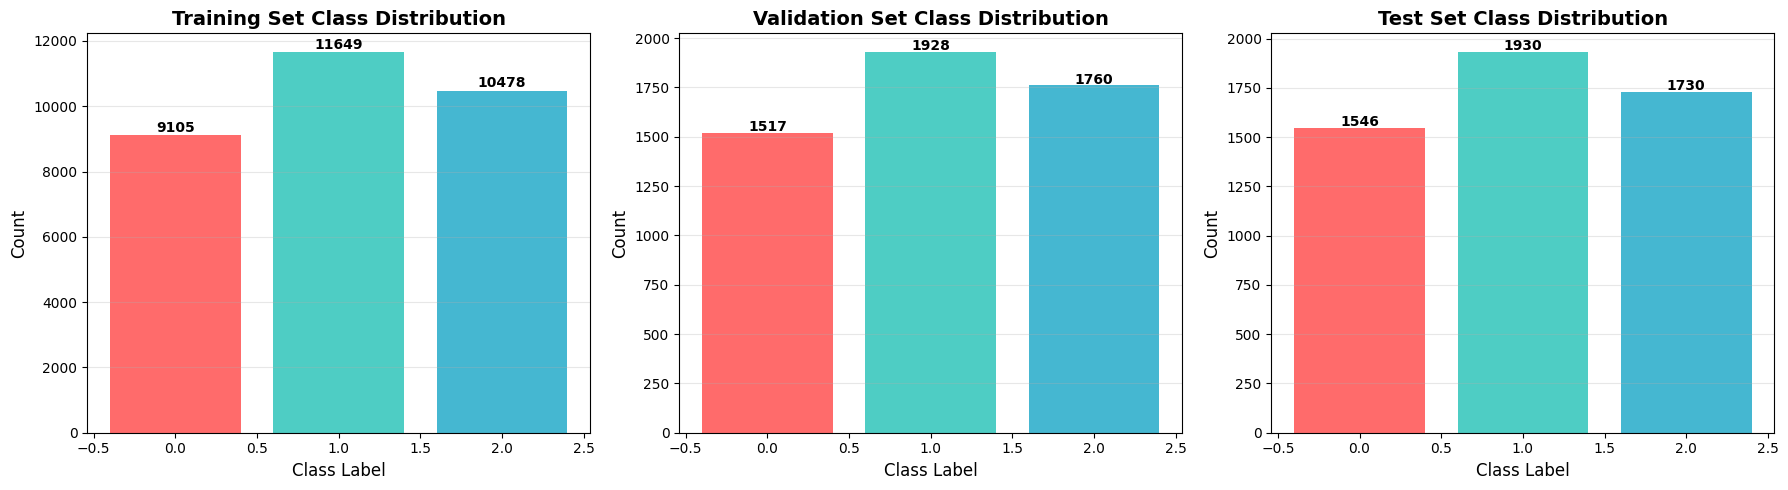


📈 Class Balance Analysis:
Training set balance: [ 9105 11649 10478]
Balance ratio (max/min): 1.28


In [5]:
# CELL 5: VISUALIZATION 1 - CLASS DISTRIBUTION
# ============================================

print("📊 Creating Class Distribution Visualization...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training set distribution
train_counts = train_df[LABEL_COL].value_counts().sort_index()
axes[0].bar(train_counts.index, train_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class Label', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(train_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# Validation set distribution
val_counts = val_df[LABEL_COL].value_counts().sort_index()
axes[1].bar(val_counts.index, val_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_title('Validation Set Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class Label', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(val_counts.values):
    axes[1].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Test set distribution
test_counts = test_df[LABEL_COL].value_counts().sort_index()
axes[2].bar(test_counts.index, test_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[2].set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Class Label', fontsize=12)
axes[2].set_ylabel('Count', fontsize=12)
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_counts.values):
    axes[2].text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Print class balance statistics
print("\n📈 Class Balance Analysis:")
print(f"Training set balance: {train_counts.values}")
print(f"Balance ratio (max/min): {train_counts.max() / train_counts.min():.2f}")

📊 Creating Text Length Distribution Visualization...


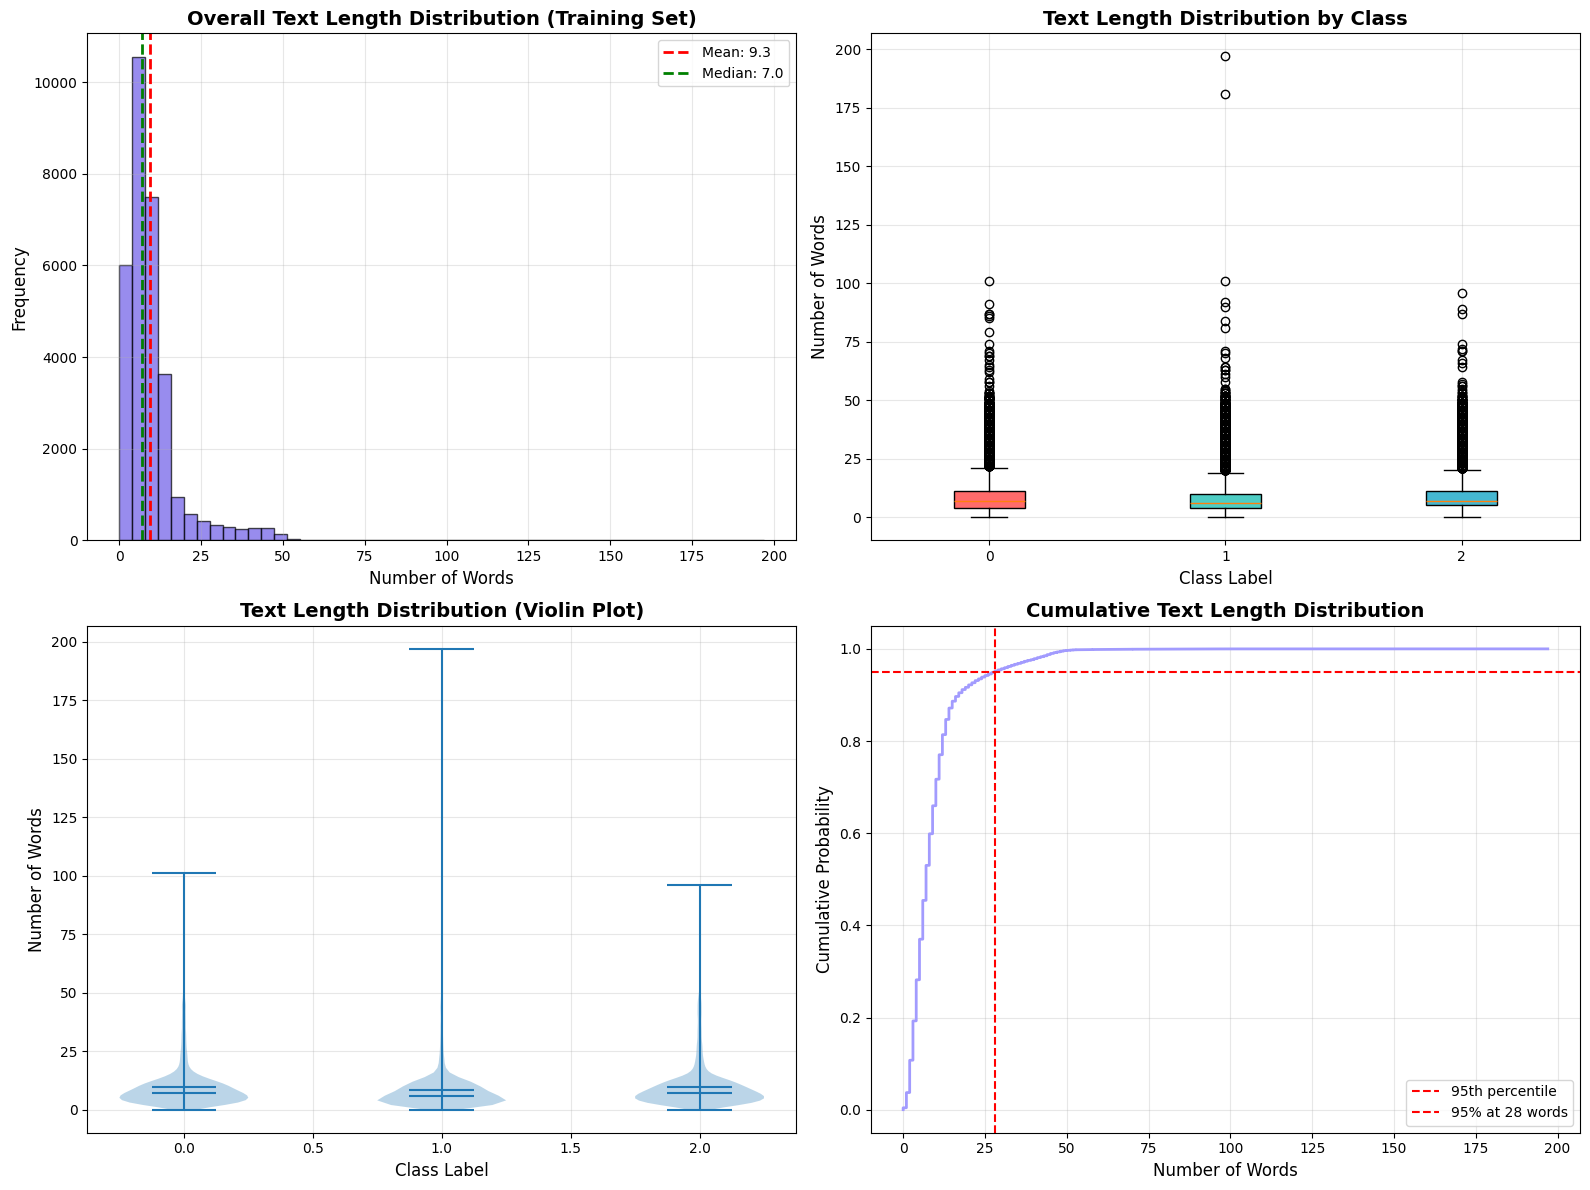


📊 Text Length Statistics:
Mean length: 9.33 words
Median length: 7.00 words
Min length: 0 words
Max length: 197 words
95th percentile: 28 words


In [6]:
# CELL 6: VISUALIZATION 2 - TEXT LENGTH DISTRIBUTION
# ============================================

print("📊 Creating Text Length Distribution Visualization...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Overall text length distribution
axes[0, 0].hist(train_df['text_length'], bins=50, color='#6C5CE7', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(train_df['text_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {train_df["text_length"].mean():.1f}')
axes[0, 0].axvline(train_df['text_length'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {train_df["text_length"].median():.1f}')
axes[0, 0].set_title('Overall Text Length Distribution (Training Set)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Words', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Text length by class (box plot)
class_lengths = [train_df[train_df[LABEL_COL] == i]['text_length'].values for i in sorted(train_df[LABEL_COL].unique())]
bp = axes[0, 1].boxplot(class_lengths, labels=sorted(train_df[LABEL_COL].unique()), patch_artist=True)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 1].set_title('Text Length Distribution by Class', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Class Label', fontsize=12)
axes[0, 1].set_ylabel('Number of Words', fontsize=12)
axes[0, 1].grid(alpha=0.3)

# Violin plot for detailed distribution
train_df_plot = train_df.copy()
train_df_plot['label_str'] = train_df_plot[LABEL_COL].astype(str)
parts = axes[1, 0].violinplot([train_df[train_df[LABEL_COL] == i]['text_length'].values for i in sorted(train_df[LABEL_COL].unique())],
                               positions=sorted(train_df[LABEL_COL].unique()),
                               showmeans=True, showmedians=True)
axes[1, 0].set_title('Text Length Distribution (Violin Plot)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Class Label', fontsize=12)
axes[1, 0].set_ylabel('Number of Words', fontsize=12)
axes[1, 0].grid(alpha=0.3)

# Cumulative distribution
sorted_lengths = np.sort(train_df['text_length'])
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
axes[1, 1].plot(sorted_lengths, cumulative, linewidth=2, color='#A29BFE')
axes[1, 1].axhline(0.95, color='red', linestyle='--', label='95th percentile')
percentile_95 = np.percentile(train_df['text_length'], 95)
axes[1, 1].axvline(percentile_95, color='red', linestyle='--', label=f'95% at {percentile_95:.0f} words')
axes[1, 1].set_title('Cumulative Text Length Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Words', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\n📊 Text Length Statistics:")
print(f"Mean length: {train_df['text_length'].mean():.2f} words")
print(f"Median length: {train_df['text_length'].median():.2f} words")
print(f"Min length: {train_df['text_length'].min()} words")
print(f"Max length: {train_df['text_length'].max()} words")
print(f"95th percentile: {percentile_95:.0f} words")

📊 Creating Vocabulary Analysis Visualization...


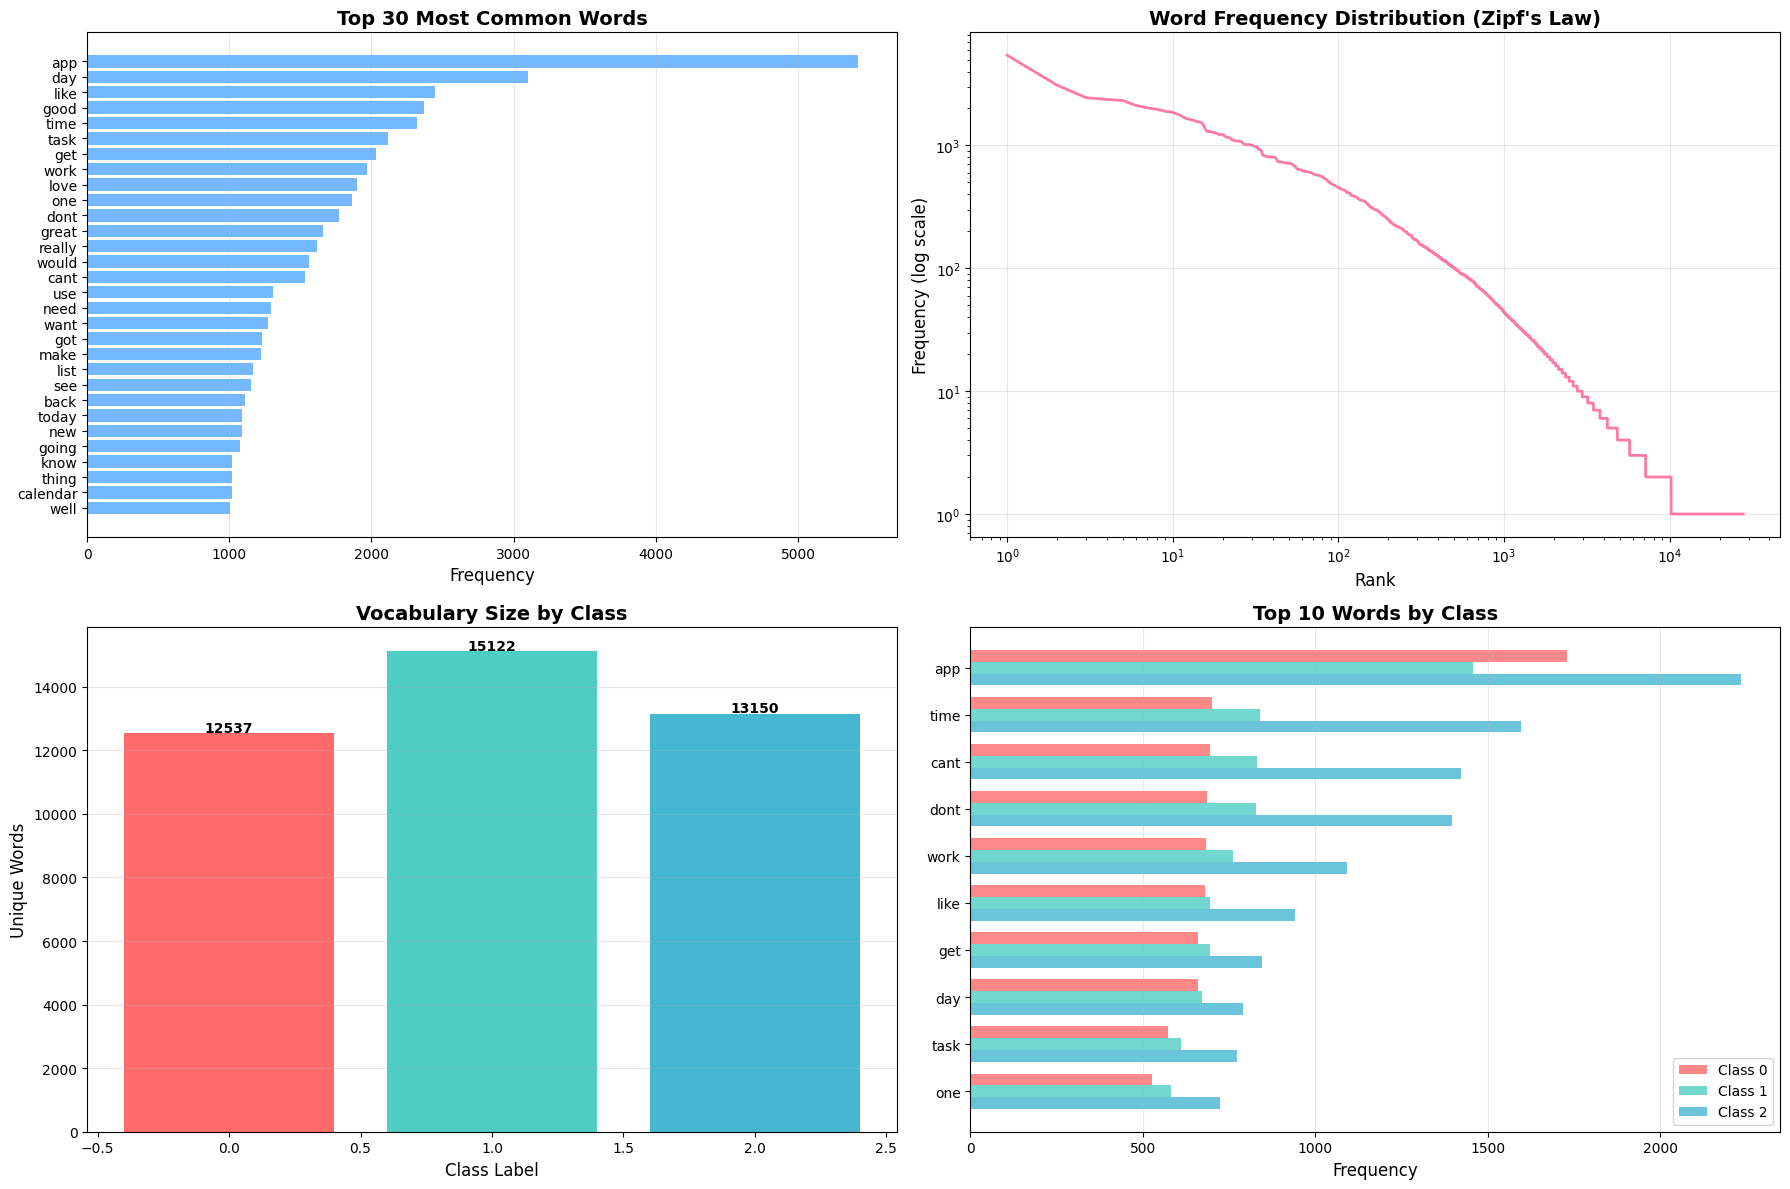


📚 Vocabulary Statistics:
Total vocabulary size: 27,801 unique words
Total word occurrences: 291,451
Average word frequency: 10.48

Vocabulary size by class:
  Class 0: 12,537 unique words
  Class 1: 15,122 unique words
  Class 2: 13,150 unique words


In [7]:
# CELL 7: VISUALIZATION 3 - VOCABULARY ANALYSIS
# ============================================

print("📊 Creating Vocabulary Analysis Visualization...")

from collections import Counter

# Build vocabulary
all_words = [word for tokens in train_df['cleaned_text_tokens'] for word in tokens]
word_freq = Counter(all_words)
vocab_size = len(word_freq)

# Get top words
top_30_words = word_freq.most_common(30)

# Get vocabulary by class
vocab_by_class = {}
for label in sorted(train_df[LABEL_COL].unique()):
    class_words = [word for tokens in train_df[train_df[LABEL_COL] == label]['cleaned_text_tokens'] for word in tokens]
    vocab_by_class[label] = Counter(class_words)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top 30 most common words
words, counts = zip(*top_30_words)
axes[0, 0].barh(range(len(words)), counts, color='#74B9FF')
axes[0, 0].set_yticks(range(len(words)))
axes[0, 0].set_yticklabels(words)
axes[0, 0].invert_yaxis()
axes[0, 0].set_title('Top 30 Most Common Words', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Frequency', fontsize=12)
axes[0, 0].grid(axis='x', alpha=0.3)

# Word frequency distribution (Zipf's law)
sorted_freqs = sorted(word_freq.values(), reverse=True)
axes[0, 1].loglog(range(1, len(sorted_freqs) + 1), sorted_freqs, color='#FD79A8', linewidth=2)
axes[0, 1].set_title("Word Frequency Distribution (Zipf's Law)", fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Rank', fontsize=12)
axes[0, 1].set_ylabel('Frequency (log scale)', fontsize=12)
axes[0, 1].grid(alpha=0.3)

# Vocabulary size by class
class_vocab_sizes = [len(vocab_by_class[label]) for label in sorted(vocab_by_class.keys())]
axes[1, 0].bar(sorted(vocab_by_class.keys()), class_vocab_sizes, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1, 0].set_title('Vocabulary Size by Class', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Class Label', fontsize=12)
axes[1, 0].set_ylabel('Unique Words', fontsize=12)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_vocab_sizes):
    axes[1, 0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Top 15 words per class
colors_class = ['#FF6B6B', '#4ECDC4', '#45B7D1']
x_offset = 0
bar_width = 0.25
word_positions = {}

for idx, label in enumerate(sorted(vocab_by_class.keys())):
    top_10 = vocab_by_class[label].most_common(10)
    words_class, counts_class = zip(*top_10)
    positions = [i + (idx * bar_width) for i in range(len(words_class))]
    axes[1, 1].barh(positions, counts_class, bar_width, label=f'Class {label}', color=colors_class[idx], alpha=0.8)

    if idx == 0:
        for i, word in enumerate(words_class):
            word_positions[i] = word

axes[1, 1].set_yticks([i + bar_width for i in range(10)])
axes[1, 1].set_yticklabels([word_positions.get(i, '') for i in range(10)])
axes[1, 1].invert_yaxis()
axes[1, 1].set_title('Top 10 Words by Class', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Frequency', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📚 Vocabulary Statistics:")
print(f"Total vocabulary size: {vocab_size:,} unique words")
print(f"Total word occurrences: {len(all_words):,}")
print(f"Average word frequency: {len(all_words)/vocab_size:.2f}")
print(f"\nVocabulary size by class:")
for label in sorted(vocab_by_class.keys()):
    print(f"  Class {label}: {len(vocab_by_class[label]):,} unique words")

📊 Creating Word Clouds and Dataset Overview...


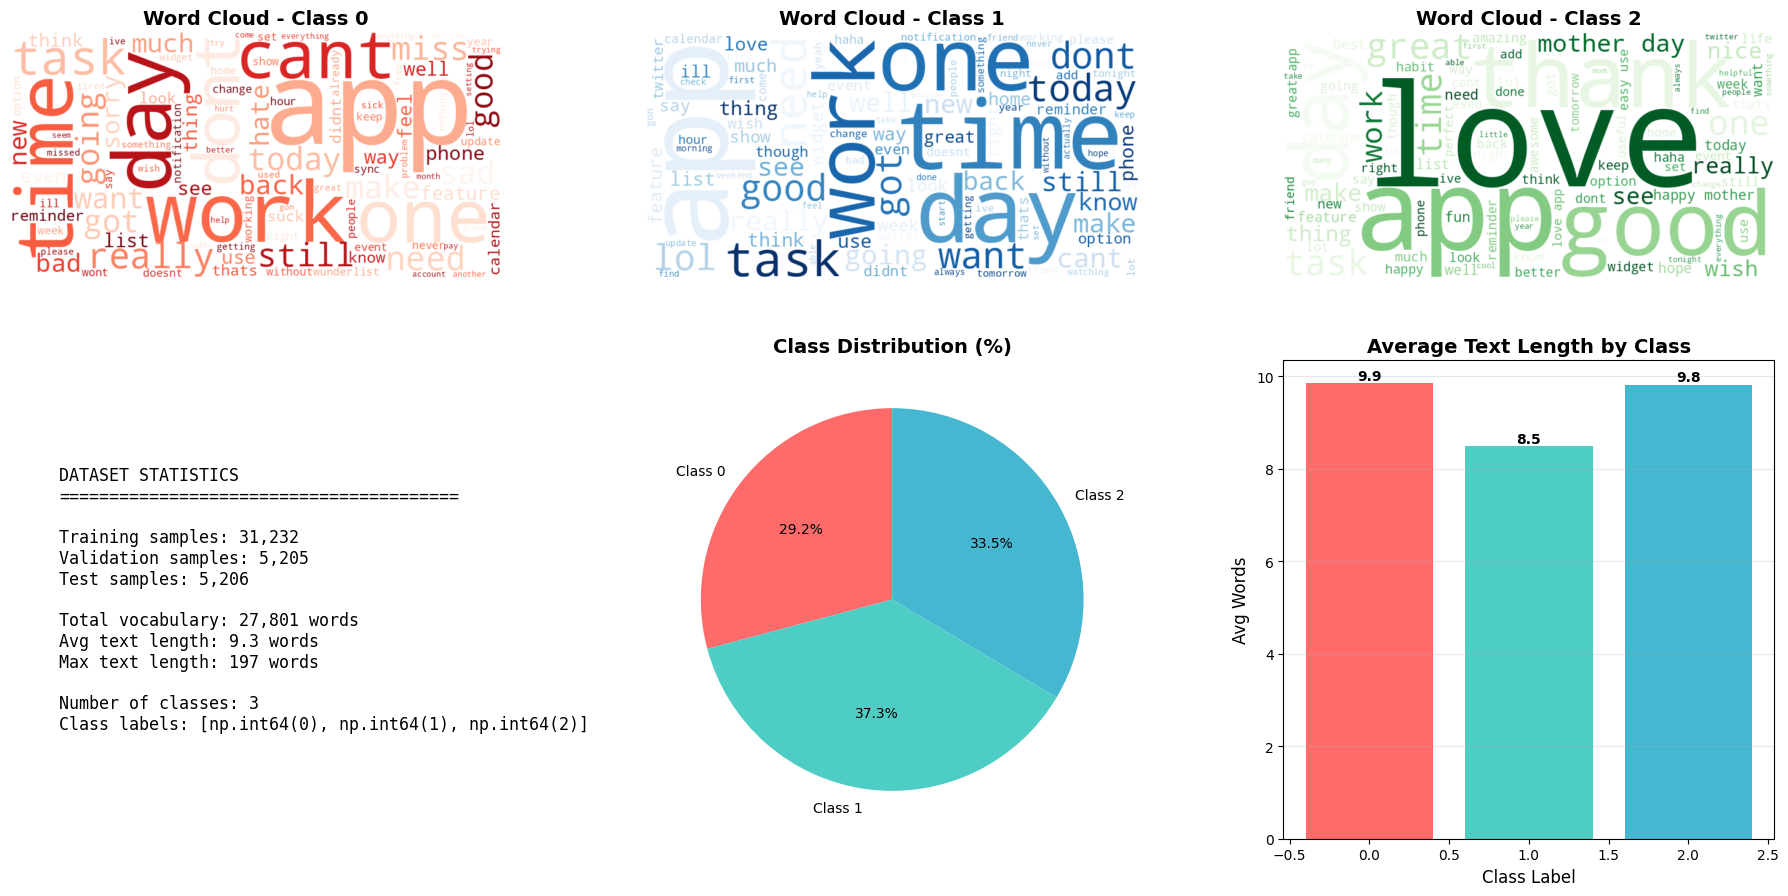


✅ All visualizations complete!


In [8]:
# CELL 8: VISUALIZATION 4 - WORD CLOUD AND DATASET OVERVIEW
# ============================================

print("📊 Creating Word Clouds and Dataset Overview...")

from wordcloud import WordCloud

fig = plt.figure(figsize=(18, 10))

# Create word clouds for each class
for idx, label in enumerate(sorted(train_df[LABEL_COL].unique())):
    ax = plt.subplot(2, 3, idx + 1)
    class_text = ' '.join([word for tokens in train_df[train_df[LABEL_COL] == label]['cleaned_text_tokens'] for word in tokens])

    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         colormap=['Reds', 'Blues', 'Greens'][idx],
                         max_words=100).generate(class_text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud - Class {label}', fontsize=14, fontweight='bold')
    ax.axis('off')

# Dataset statistics overview
ax = plt.subplot(2, 3, 4)
stats_text = f"""
DATASET STATISTICS
{'='*40}

Training samples: {len(train_df):,}
Validation samples: {len(val_df):,}
Test samples: {len(test_df):,}

Total vocabulary: {vocab_size:,} words
Avg text length: {train_df['text_length'].mean():.1f} words
Max text length: {train_df['text_length'].max()} words

Number of classes: {len(label_encoder.classes_)}
Class labels: {list(sorted(train_df[LABEL_COL].unique()))}
"""
ax.text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
        verticalalignment='center')
ax.axis('off')

# Class distribution pie chart
ax = plt.subplot(2, 3, 5)
class_counts = train_df[LABEL_COL].value_counts().sort_index()
colors_pie = ['#FF6B6B', '#4ECDC4', '#45B7D1']
ax.pie(class_counts.values, labels=[f'Class {i}' for i in class_counts.index],
       autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax.set_title('Class Distribution (%)', fontsize=14, fontweight='bold')

# Average text length per class
ax = plt.subplot(2, 3, 6)
avg_lengths = train_df.groupby(LABEL_COL)['text_length'].mean().sort_index()
bars = ax.bar(avg_lengths.index, avg_lengths.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax.set_title('Average Text Length by Class', fontsize=14, fontweight='bold')
ax.set_xlabel('Class Label', fontsize=12)
ax.set_ylabel('Avg Words', fontsize=12)
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ All visualizations complete!")

# PREPROCESSING DADTA

In [3]:
# CELL 3: TEXT PREPROCESSING CLASS
# ============================================

class TextPreprocessor:
    """Preprocess text for different embedding methods"""

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text, for_word2vec=True):
        """
        Clean and preprocess text
        for_word2vec=True: Returns tokenized list of words
        for_word2vec=False: Returns cleaned string for TF-IDF
        """
        if not isinstance(text, str):
            return "" if not for_word2vec else []

        # Convert to lowercase
        text = text.lower()

        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Tokenize
        tokens = word_tokenize(text)

        # Remove stopwords and short words
        tokens = [word for word in tokens if word not in self.stop_words and len(word) > 2]

        # Lemmatize
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens]

        if for_word2vec:
            return tokens
        else:
            return ' '.join(tokens)

# Initialize preprocessor
preprocessor = TextPreprocessor()
print("✅ Text preprocessor initialized!")

✅ Text preprocessor initialized!


In [4]:
# CELL 4: PREPROCESS ALL DATA
# ============================================

print("🔄 Preprocessing text...")

# Preprocess training data
train_df['cleaned_text_str'] = train_df[TEXT_COL].apply(
    lambda x: preprocessor.clean_text(x, for_word2vec=False)
)
train_df['cleaned_text_tokens'] = train_df[TEXT_COL].apply(
    lambda x: preprocessor.clean_text(x, for_word2vec=True)
)

# Preprocess validation data
val_df['cleaned_text_str'] = val_df[TEXT_COL].apply(
    lambda x: preprocessor.clean_text(x, for_word2vec=False)
)
val_df['cleaned_text_tokens'] = val_df[TEXT_COL].apply(
    lambda x: preprocessor.clean_text(x, for_word2vec=True)
)

# Preprocess test data
test_df['cleaned_text_str'] = test_df[TEXT_COL].apply(
    lambda x: preprocessor.clean_text(x, for_word2vec=False)
)
test_df['cleaned_text_tokens'] = test_df[TEXT_COL].apply(
    lambda x: preprocessor.clean_text(x, for_word2vec=True)
)

# Calculate text lengths for analysis
train_df['text_length'] = train_df['cleaned_text_tokens'].apply(len)
val_df['text_length'] = val_df['cleaned_text_tokens'].apply(len)
test_df['text_length'] = test_df['cleaned_text_tokens'].apply(len)

# Prepare features
X_train_str = train_df['cleaned_text_str']
X_train_tokens = train_df['cleaned_text_tokens']

X_val_str = val_df['cleaned_text_str']
X_val_tokens = val_df['cleaned_text_tokens']

X_test_str = test_df['cleaned_text_str']
X_test_tokens = test_df['cleaned_text_tokens']

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df[LABEL_COL])
y_val = label_encoder.transform(val_df[LABEL_COL])
y_test = label_encoder.transform(test_df[LABEL_COL])

print(f"✅ Preprocessing complete!")
print(f"   - Training samples: {len(X_train_str)}")
print(f"   - Validation samples: {len(X_val_str)}")
print(f"   - Test samples: {len(X_test_str)}")
print(f"   - Number of classes: {len(label_encoder.classes_)}")

🔄 Preprocessing text...
✅ Preprocessing complete!
   - Training samples: 31232
   - Validation samples: 5205
   - Test samples: 5206
   - Number of classes: 3


# GRU MODEL

This section shows the implementation of GRU models with three different embedding techniques:
1. **TF-IDF + Dense Layers**: Traditional approach using TF-IDF features
2. **Word2Vec Embeddings**: Custom trained Word2Vec embeddings
3. **GloVe Embeddings**: Pre-trained GloVe embeddings

Each technique will have 2 experiments with different hyperparameters.

In [9]:
# CELL 9: HELPER FUNCTIONS FOR GRU MODELS (WITH CONFUSION MATRIX)
# ============================================

# Store experiment results
experiment_results = []

def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plot confusion matrix with heatmap"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1', 'Class 2'],
                yticklabels=['Class 0', 'Class 1', 'Class 2'],
                cbar_kws={'label': 'Count'})
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)

    # Add accuracy per class
    class_acc = cm.diagonal() / cm.sum(axis=1)
    for i, acc in enumerate(class_acc):
        plt.text(3.5, i + 0.5, f'{acc:.2%}', va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model and return metrics with confusion matrix"""
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n{'='*60}")
    print(f"📊 {model_name} - Test Results")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"{'='*60}\n")

    # Print classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, model_name)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def plot_training_history(history, model_name):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, marker='s')
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2, marker='o')
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2, marker='s')
    axes[1].set_title(f'{model_name} - Loss', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

print("✅ Helper functions defined (with confusion matrix support)!")

✅ Helper functions defined (with confusion matrix support)!


## APPROACH 1: TF-IDF + GRU

**Architecture Description:**
- TF-IDF vectorization to convert text to numerical features
- Reshape TF-IDF features for GRU input (treat each feature as a timestep)
- GRU layers to capture sequential patterns in TF-IDF features
- Dense layers for classification

**Justification:**
- TF-IDF captures word importance across documents
- GRU can learn temporal dependencies even in TF-IDF representation
- Simple and fast to train
- Good baseline for comparison

In [10]:
# CELL 10: TF-IDF VECTORIZATION
# ============================================

print("🔄 Creating TF-IDF features...")

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train_str).toarray()
X_val_tfidf = tfidf.transform(X_val_str).toarray()
X_test_tfidf = tfidf.transform(X_test_str).toarray()

# Reshape for GRU (samples, timesteps, features)
# We'll treat each TF-IDF feature as a timestep with 1 feature
X_train_tfidf_reshaped = X_train_tfidf.reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1)
X_val_tfidf_reshaped = X_val_tfidf.reshape(X_val_tfidf.shape[0], X_val_tfidf.shape[1], 1)
X_test_tfidf_reshaped = X_test_tfidf.reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1)

print(f"✅ TF-IDF features created!")
print(f"   Shape: {X_train_tfidf_reshaped.shape}")

🔄 Creating TF-IDF features...
✅ TF-IDF features created!
   Shape: (31232, 5000, 1)



🧪 EXPERIMENT 1: TF-IDF + Simple GRU
Configuration:
  - Single GRU layer (64 units)
  - Dropout: 0.3
  - Dense layer: 32 units
  - Optimizer: Adam (lr=0.001)
  - Batch size: 32



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,043 (58.76 KB)

 Trainable params: 15,043 (58.76 KB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Training Experiment 1...

Epoch 1/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 132s 131ms/step - accuracy: 0.3636 - loss: 1.0952 - val_accuracy: 0.3704 - val_loss: 1.0942 - learning_rate: 0.0010
Epoch 2/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 127s 130ms/step - accuracy: 0.3711 - loss: 1.0938 - val_accuracy: 0.3704 - val_loss: 1.0942 - learning_rate: 0.0010
Epoch 3/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 127s 131ms/step - accuracy: 0.3716 - loss: 1.0934 - val_accuracy: 0.3704 - val_loss: 1.0941 - learning_rate: 0.0010
Epoch 4/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 125s 128ms/step - accuracy: 0.3716 - loss: 1.0933 - val_accuracy: 0.3704 - val_loss: 1.0943 - learning_rate: 0.0010
Epoch 5/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 126s 129ms/step - accuracy: 0.3701 - loss: 1.0936 - val_accuracy: 0.3704 - val_loss: 1.0941 - learning_rate: 0.0010
Epoch 6/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 125s 128ms/step - accuracy: 0.3716 - loss: 1.0933 - val_accuracy: 0.3704 - val_loss: 1.0939 - learning_rate: 5.0000e-04
Epoch 7/10
976/976 ━━━━━━━

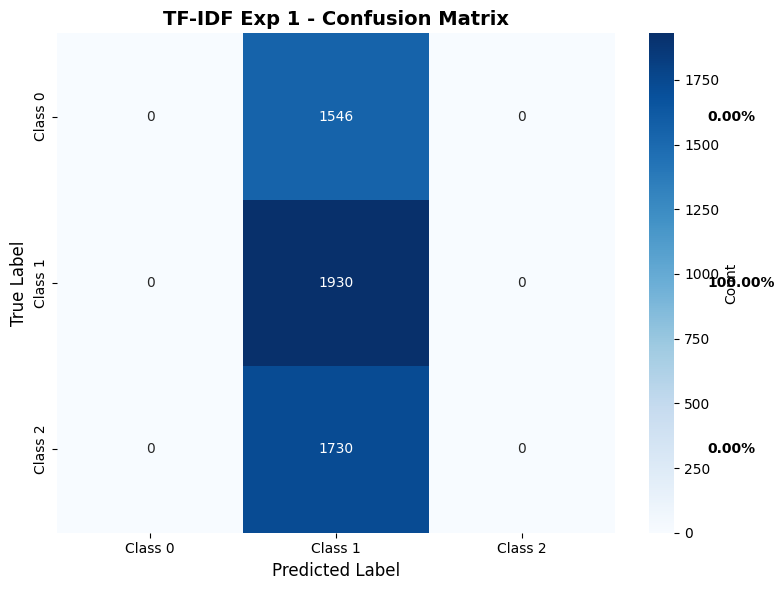

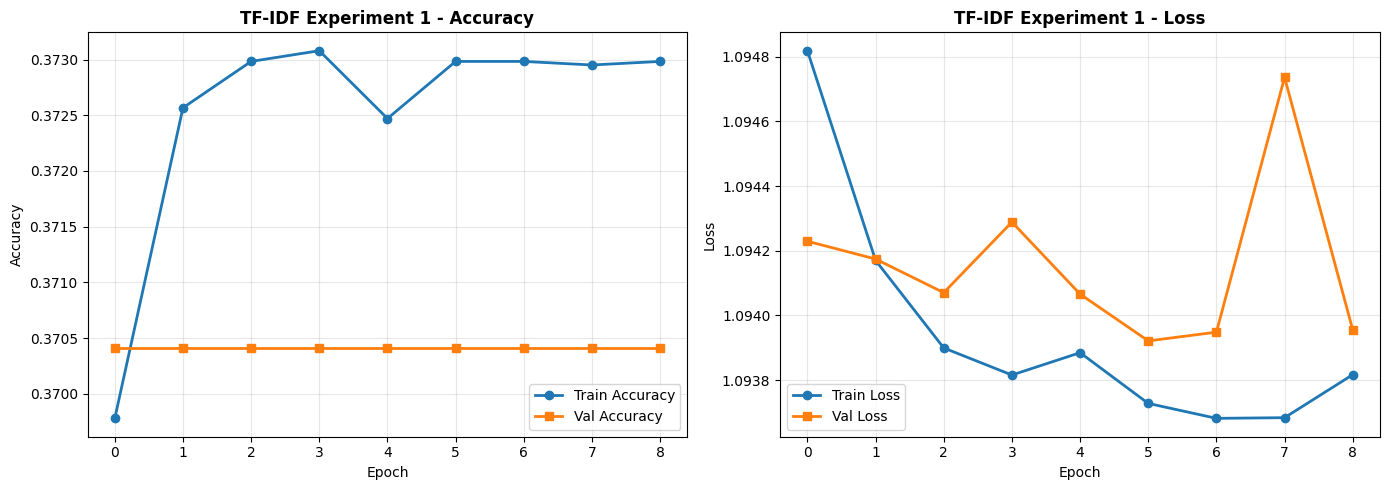

In [11]:
# CELL 11: EXPERIMENT 1 - TF-IDF + Simple GRU
# ============================================
# Variation: Simple architecture with single GRU layer, moderate regularization

print("\n" + "="*70)
print("🧪 EXPERIMENT 1: TF-IDF + Simple GRU")
print("="*70)
print("Configuration:")
print("  - Single GRU layer (64 units)")
print("  - Dropout: 0.3")
print("  - Dense layer: 32 units")
print("  - Optimizer: Adam (lr=0.001)")
print("  - Batch size: 32")
print("="*70 + "\n")

# Build model
model_tfidf_1 = Sequential([
    GRU(64, input_shape=(X_train_tfidf_reshaped.shape[1], 1), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_tfidf_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Build model to show shapes
model_tfidf_1.build(input_shape=(None, X_train_tfidf_reshaped.shape[1], 1))
print(model_tfidf_1.summary())

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

# Train
print("\n🚀 Training Experiment 1...\n")
history_tfidf_1 = model_tfidf_1.fit(
    X_train_tfidf_reshaped, y_train,
    validation_data=(X_val_tfidf_reshaped, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
metrics_tfidf_1 = evaluate_model(model_tfidf_1, X_test_tfidf_reshaped, y_test, "TF-IDF Exp 1")
plot_training_history(history_tfidf_1, "TF-IDF Experiment 1")

# Store results
experiment_results.append({
    'Experiment': 'TF-IDF Exp 1',
    'Embedding': 'TF-IDF',
    'Description': 'Simple GRU (64 units), Dropout 0.3',
    **metrics_tfidf_1
})


🧪 EXPERIMENT 2: TF-IDF + Bidirectional GRU
Configuration:
  - Bidirectional GRU layer (128 units total)
  - Dropout: 0.4
  - Dense layers: 64 → 32 units
  - Optimizer: Adam (lr=0.001)
  - Batch size: 64



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,163 (141.26 KB)

 Trainable params: 36,163 (141.26 KB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Training Experiment 2...

Epoch 1/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 135s 267ms/step - accuracy: 0.3615 - loss: 1.0951 - val_accuracy: 0.3704 - val_loss: 1.0942 - learning_rate: 0.0010
Epoch 2/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 130s 266ms/step - accuracy: 0.3710 - loss: 1.0937 - val_accuracy: 0.3704 - val_loss: 1.0941 - learning_rate: 0.0010
Epoch 3/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 130s 266ms/step - accuracy: 0.3716 - loss: 1.0935 - val_accuracy: 0.3704 - val_loss: 1.0940 - learning_rate: 0.0010
Epoch 4/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 137s 282ms/step - accuracy: 0.3716 - loss: 1.0935 - val_accuracy: 0.3704 - val_loss: 1.0940 - learning_rate: 0.0010
Epoch 5/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 131s 269ms/step - accuracy: 0.3716 - loss: 1.0932 - val_accuracy: 0.3704 - val_loss: 1.0940 - learning_rate: 5.0000e-04
Epoch 6/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 130s 266ms/step - accuracy: 0.3716 - loss: 1.0934 - val_accuracy: 0.3704 - val_loss: 1.0939 - learning_rate: 5.0000e-04
Epoch 7/10
488/488 ━━━

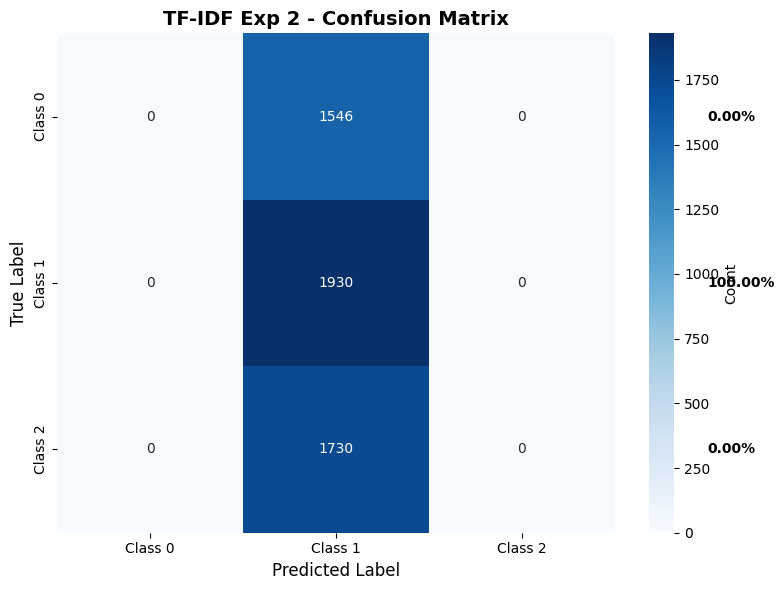

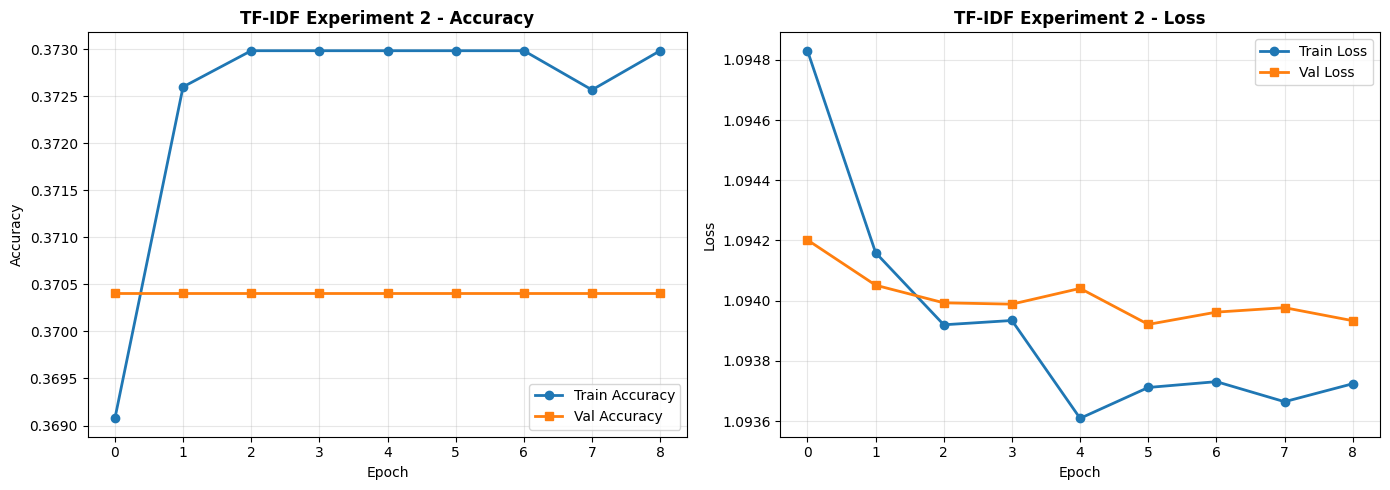

In [12]:
# CELL 12: EXPERIMENT 2 - TF-IDF + Bidirectional GRU
# ============================================
# Variation: Bidirectional GRU for better context, higher capacity, stronger regularization

print("\n" + "="*70)
print("🧪 EXPERIMENT 2: TF-IDF + Bidirectional GRU")
print("="*70)
print("Configuration:")
print("  - Bidirectional GRU layer (128 units total)")
print("  - Dropout: 0.4")
print("  - Dense layers: 64 → 32 units")
print("  - Optimizer: Adam (lr=0.001)")
print("  - Batch size: 64")
print("="*70 + "\n")

# Build model
model_tfidf_2 = Sequential([
    Bidirectional(GRU(64, return_sequences=False), input_shape=(X_train_tfidf_reshaped.shape[1], 1)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_tfidf_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Build model to show shapes
model_tfidf_2.build(input_shape=(None, X_train_tfidf_reshaped.shape[1], 1))
print(model_tfidf_2.summary())

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

# Train
print("\n🚀 Training Experiment 2...\n")
history_tfidf_2 = model_tfidf_2.fit(
    X_train_tfidf_reshaped, y_train,
    validation_data=(X_val_tfidf_reshaped, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
metrics_tfidf_2 = evaluate_model(model_tfidf_2, X_test_tfidf_reshaped, y_test, "TF-IDF Exp 2")
plot_training_history(history_tfidf_2, "TF-IDF Experiment 2")

# Store results
experiment_results.append({
    'Experiment': 'TF-IDF Exp 2',
    'Embedding': 'TF-IDF',
    'Description': 'Bidirectional GRU (128 total), Dropout 0.4',
    **metrics_tfidf_2
})

## APPROACH 2: Word2Vec Embeddings + GRU

**Architecture Description:**
- Train custom Word2Vec embeddings on our corpus
- Create embedding matrix for trainable embedding layer
- Embedding layer converts word indices to dense vectors
- GRU layers process sequential word embeddings
- Dense layers for classification

**Justification:**
- Word2Vec captures semantic word relationships from our specific domain
- Custom training ensures embeddings match our vocabulary
- GRU naturally processes sequential word embeddings
- Better context understanding than TF-IDF

In [13]:
# CELL 13: WORD2VEC PREPARATION
# ============================================

print("🔄 Training Word2Vec model...")

# Train Word2Vec on our corpus
w2v_model = Word2Vec(
    sentences=X_train_tokens.tolist(),
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=10
)

print(f"✅ Word2Vec trained! Vocabulary size: {len(w2v_model.wv)}")

# Prepare sequences
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 10000

# Tokenize and create sequences
tokenizer_w2v = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer_w2v.fit_on_texts([' '.join(tokens) for tokens in X_train_tokens])

X_train_seq_w2v = tokenizer_w2v.texts_to_sequences([' '.join(tokens) for tokens in X_train_tokens])
X_val_seq_w2v = tokenizer_w2v.texts_to_sequences([' '.join(tokens) for tokens in X_val_tokens])
X_test_seq_w2v = tokenizer_w2v.texts_to_sequences([' '.join(tokens) for tokens in X_test_tokens])

# Pad sequences
X_train_padded_w2v = pad_sequences(X_train_seq_w2v, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val_padded_w2v = pad_sequences(X_val_seq_w2v, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_padded_w2v = pad_sequences(X_test_seq_w2v, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Create embedding matrix
vocab_size = min(len(tokenizer_w2v.word_index) + 1, MAX_VOCAB_SIZE)
embedding_dim = 100
embedding_matrix_w2v = np.zeros((vocab_size, embedding_dim))

for word, idx in tokenizer_w2v.word_index.items():
    if idx >= MAX_VOCAB_SIZE:
        continue
    if word in w2v_model.wv:
        embedding_matrix_w2v[idx] = w2v_model.wv[word]

print(f"✅ Embedding matrix created! Shape: {embedding_matrix_w2v.shape}")
print(f"   Padded sequences shape: {X_train_padded_w2v.shape}")

🔄 Training Word2Vec model...
✅ Word2Vec trained! Vocabulary size: 10194
✅ Embedding matrix created! Shape: (10000, 100)
   Padded sequences shape: (31232, 100)



🧪 EXPERIMENT 3: Word2Vec + Single GRU
Configuration:
  - Word2Vec embeddings (100-dim, trainable)
  - Single GRU layer (128 units)
  - SpatialDropout1D: 0.3
  - Dense layer: 64 units
  - Optimizer: Adam (lr=0.001)
  - Batch size: 64



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 128)            │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,096,771 (4.18 MB)

 Trainable params: 1,096,771 (4.18 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Training Experiment 3...

Epoch 1/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.3622 - loss: 1.0947 - val_accuracy: 0.3704 - val_loss: 1.0943 - learning_rate: 0.0010
Epoch 2/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3695 - loss: 1.0940 - val_accuracy: 0.3704 - val_loss: 1.0956 - learning_rate: 0.0010
Epoch 3/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3714 - loss: 1.0938 - val_accuracy: 0.3704 - val_loss: 1.0944 - learning_rate: 0.0010
Epoch 4/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3716 - loss: 1.0937 - val_accuracy: 0.3704 - val_loss: 1.0942 - learning_rate: 5.0000e-04
Epoch 5/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3716 - loss: 1.0936 - val_accuracy: 0.3704 - val_loss: 1.0940 - learning_rate: 5.0000e-04
Epoch 6/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3716 - loss: 1.0933 - val_accuracy: 0.3704 - val_loss: 1.0941 - learning_rate: 5.0000e-04
Epoch 7/20
488/488 ━━━━━━━━━━━━━━━━━━━

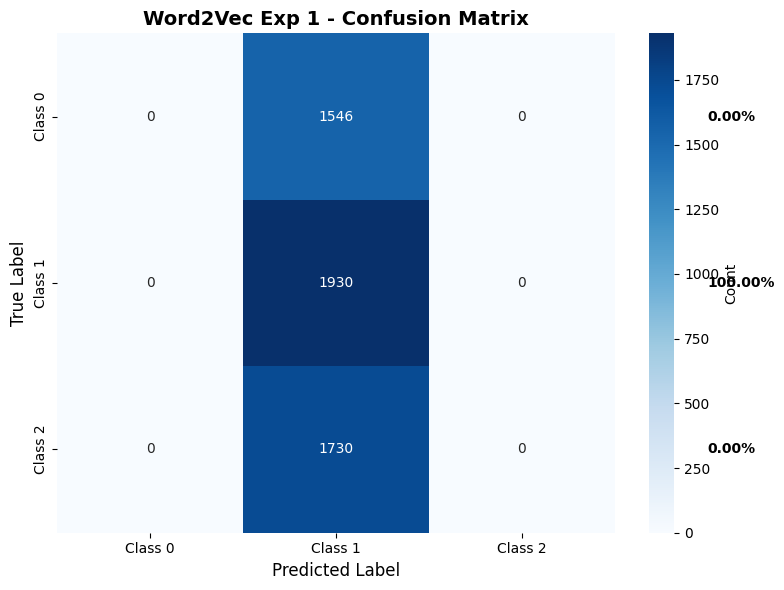

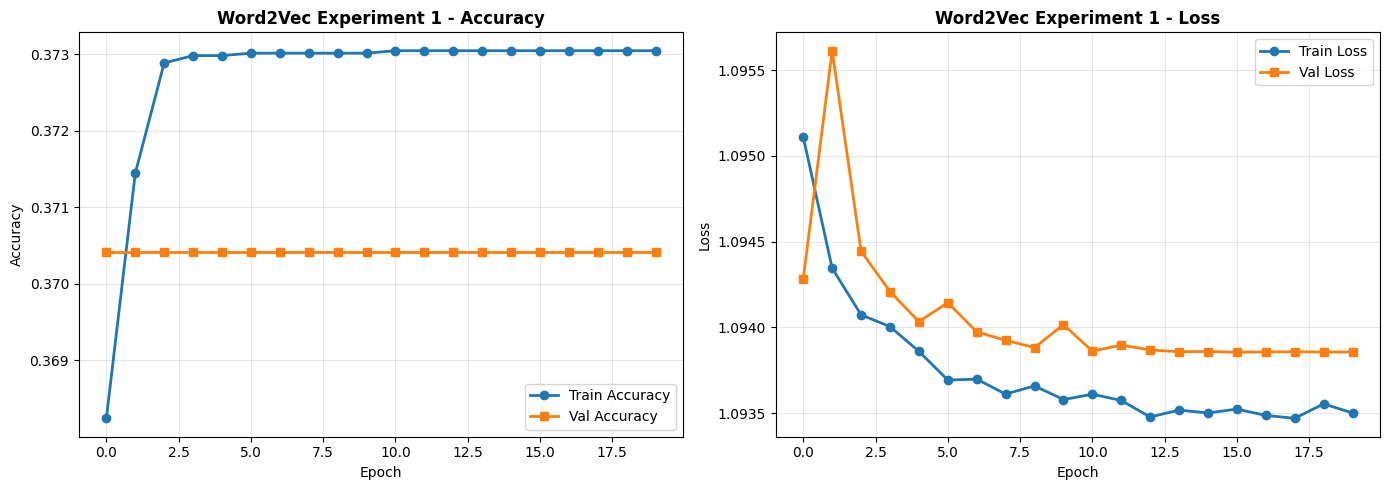

In [14]:
# CELL 14: EXPERIMENT 3 - Word2Vec + Single GRU
# ============================================
# Variation: Single GRU layer with trainable embeddings, moderate depth

print("\n" + "="*70)
print("🧪 EXPERIMENT 3: Word2Vec + Single GRU")
print("="*70)
print("Configuration:")
print("  - Word2Vec embeddings (100-dim, trainable)")
print("  - Single GRU layer (128 units)")
print("  - SpatialDropout1D: 0.3")
print("  - Dense layer: 64 units")
print("  - Optimizer: Adam (lr=0.001)")
print("  - Batch size: 64")
print("="*70 + "\n")

# Build model
model_w2v_1 = Sequential([
    Embedding(vocab_size, embedding_dim,
              weights=[embedding_matrix_w2v],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True),
    SpatialDropout1D(0.3),
    GRU(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_w2v_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Build model to show shapes
model_w2v_1.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
print(model_w2v_1.summary())

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

# Train
print("\n🚀 Training Experiment 3...\n")
history_w2v_1 = model_w2v_1.fit(
    X_train_padded_w2v, y_train,
    validation_data=(X_val_padded_w2v, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
metrics_w2v_1 = evaluate_model(model_w2v_1, X_test_padded_w2v, y_test, "Word2Vec Exp 1")
plot_training_history(history_w2v_1, "Word2Vec Experiment 1")

# Store results
experiment_results.append({
    'Experiment': 'Word2Vec Exp 1',
    'Embedding': 'Word2Vec',
    'Description': 'Single GRU (128 units), Trainable embeddings',
    **metrics_w2v_1
})


🧪 EXPERIMENT 4: Word2Vec + Stacked GRU
Configuration:
  - Word2Vec embeddings (100-dim, trainable)
  - Stacked GRU layers (128 → 64 units)
  - SpatialDropout1D: 0.2
  - Dense layers: 128 → 64 units
  - Optimizer: Adam (lr=0.001)
  - Batch size: 32



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 100, 128)       │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,339 (4.36 MB)

 Trainable params: 1,142,339 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Training Experiment 4...

Epoch 1/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.3624 - loss: 1.0955 - val_accuracy: 0.3704 - val_loss: 1.0946 - learning_rate: 0.0010
Epoch 2/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.3702 - loss: 1.0943 - val_accuracy: 0.3704 - val_loss: 1.0943 - learning_rate: 0.0010
Epoch 3/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.3713 - loss: 1.0935 - val_accuracy: 0.3704 - val_loss: 1.0942 - learning_rate: 0.0010
Epoch 4/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.3715 - loss: 1.0934 - val_accuracy: 0.3704 - val_loss: 1.0941 - learning_rate: 0.0010
Epoch 5/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.3716 - loss: 1.0934 - val_accuracy: 0.3704 - val_loss: 1.0941 - learning_rate: 0.0010
Epoch 6/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.3716 - loss: 1.0934 - val_accuracy: 0.3704 - val_loss: 1.0939 - learning_rate: 5.0000e-04
Epoch 7/20
976/976 ━━━━━━━━━━━━━━━━━━━

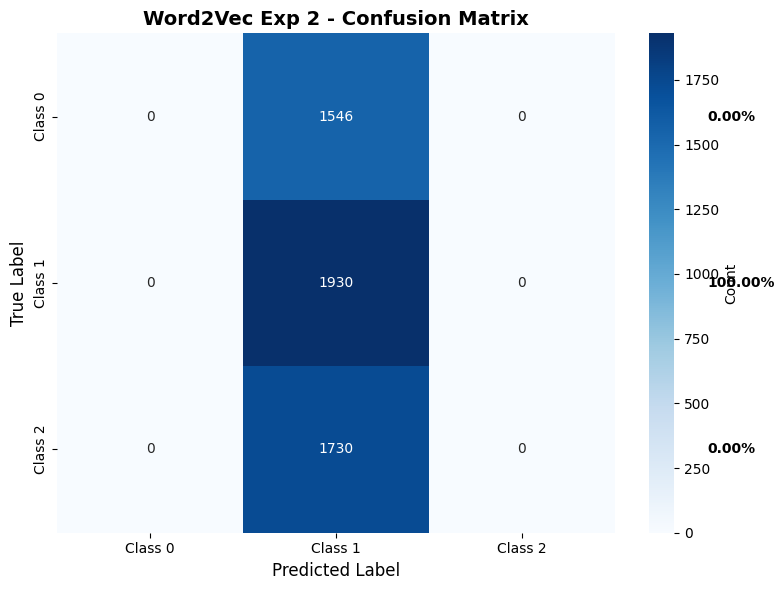

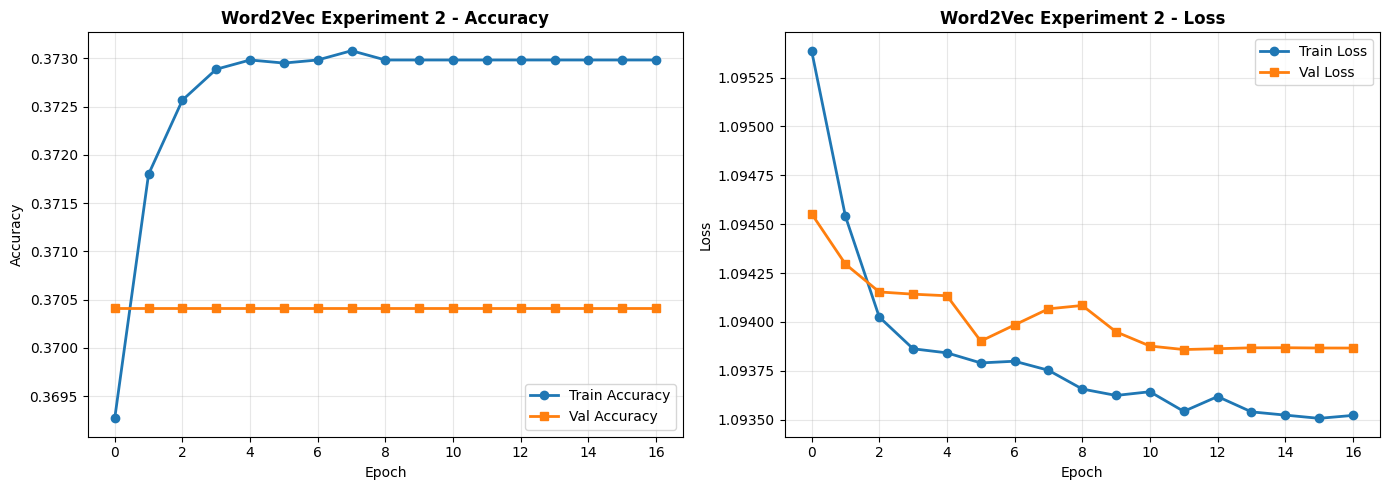

In [15]:
# CELL 15: EXPERIMENT 4 - Word2Vec + Stacked GRU
# ============================================
# Variation: Stacked GRU layers for deeper feature learning, higher capacity

print("\n" + "="*70)
print("🧪 EXPERIMENT 4: Word2Vec + Stacked GRU")
print("="*70)
print("Configuration:")
print("  - Word2Vec embeddings (100-dim, trainable)")
print("  - Stacked GRU layers (128 → 64 units)")
print("  - SpatialDropout1D: 0.2")
print("  - Dense layers: 128 → 64 units")
print("  - Optimizer: Adam (lr=0.001)")
print("  - Batch size: 32")
print("="*70 + "\n")

# Build model
model_w2v_2 = Sequential([
    Embedding(vocab_size, embedding_dim,
              weights=[embedding_matrix_w2v],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True),
    SpatialDropout1D(0.2),
    GRU(128, return_sequences=True),
    Dropout(0.3),
    GRU(64, return_sequences=False),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_w2v_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Build model to show shapes
model_w2v_2.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
print(model_w2v_2.summary())

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

# Train
print("\n🚀 Training Experiment 4...\n")
history_w2v_2 = model_w2v_2.fit(
    X_train_padded_w2v, y_train,
    validation_data=(X_val_padded_w2v, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
metrics_w2v_2 = evaluate_model(model_w2v_2, X_test_padded_w2v, y_test, "Word2Vec Exp 2")
plot_training_history(history_w2v_2, "Word2Vec Experiment 2")

# Store results
experiment_results.append({
    'Experiment': 'Word2Vec Exp 2',
    'Embedding': 'Word2Vec',
    'Description': 'Stacked GRU (128→64), Deeper network',
    **metrics_w2v_2
})

## APPROACH 3: GloVe Embeddings + GRU

**Architecture Description:**
- Load pre-trained GloVe embeddings (trained on large corpus)
- Create embedding matrix matching our vocabulary
- Embedding layer (can be frozen or trainable)
- GRU layers process sequential embeddings
- Dense layers for classification

**Justification:**
- GloVe embeddings capture global word co-occurrence statistics
- Pre-trained on massive corpus (better generalization)
- Transfer learning from broader language understanding
- Useful when training data is limited

In [16]:
# CELL 16: GLOVE PREPARATION
# ============================================

print("🔄 Loading GloVe embeddings...")

# Download GloVe embeddings (this may take a while first time)
glove_model = api.load('glove-wiki-gigaword-100')

print(f"✅ GloVe loaded! Vocabulary size: {len(glove_model)}")

# Use same tokenizer as Word2Vec for consistency
tokenizer_glove = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer_glove.fit_on_texts([' '.join(tokens) for tokens in X_train_tokens])

X_train_seq_glove = tokenizer_glove.texts_to_sequences([' '.join(tokens) for tokens in X_train_tokens])
X_val_seq_glove = tokenizer_glove.texts_to_sequences([' '.join(tokens) for tokens in X_val_tokens])
X_test_seq_glove = tokenizer_glove.texts_to_sequences([' '.join(tokens) for tokens in X_test_tokens])

# Pad sequences
X_train_padded_glove = pad_sequences(X_train_seq_glove, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val_padded_glove = pad_sequences(X_val_seq_glove, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_padded_glove = pad_sequences(X_test_seq_glove, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Create embedding matrix
vocab_size_glove = min(len(tokenizer_glove.word_index) + 1, MAX_VOCAB_SIZE)
embedding_dim_glove = 100
embedding_matrix_glove = np.zeros((vocab_size_glove, embedding_dim_glove))

found_words = 0
for word, idx in tokenizer_glove.word_index.items():
    if idx >= MAX_VOCAB_SIZE:
        continue
    if word in glove_model:
        embedding_matrix_glove[idx] = glove_model[word]
        found_words += 1

print(f"✅ GloVe embedding matrix created!")
print(f"   Shape: {embedding_matrix_glove.shape}")
print(f"   Words found in GloVe: {found_words}/{vocab_size_glove} ({100*found_words/vocab_size_glove:.1f}%)")

🔄 Loading GloVe embeddings...
[==================================================] 100.0% 128.1/128.1MB downloaded
✅ GloVe loaded! Vocabulary size: 400000
✅ GloVe embedding matrix created!
   Shape: (10000, 100)
   Words found in GloVe: 9051/10000 (90.5%)



🧪 EXPERIMENT 5: GloVe + Bidirectional GRU (Frozen)
Configuration:
  - GloVe embeddings (100-dim, frozen/non-trainable)
  - Bidirectional GRU (64 units, 128 total)
  - SpatialDropout1D: 0.3
  - Dense layer: 64 units
  - Optimizer: Adam (lr=0.001)
  - Batch size: 64



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        63,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,195 (4.09 MB)

 Trainable params: 72,195 (282.01 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

None

🚀 Training Experiment 5...

Epoch 1/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4577 - loss: 1.0350 - val_accuracy: 0.6142 - val_loss: 0.8493 - learning_rate: 0.0010
Epoch 2/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5982 - loss: 0.8850 - val_accuracy: 0.6515 - val_loss: 0.7909 - learning_rate: 0.0010
Epoch 3/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6275 - loss: 0.8409 - val_accuracy: 0.6584 - val_loss: 0.7756 - learning_rate: 0.0010
Epoch 4/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6342 - loss: 0.8255 - val_accuracy: 0.6653 - val_loss: 0.7622 - learning_rate: 0.0010
Epoch 5/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6421 - loss: 0.8099 - val_accuracy: 0.6703 - val_loss: 0.7549 - learning_rate: 0.0010
Epoch 6/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6541 - loss: 0.7955 - val_accuracy: 0.6747 - val_loss: 0.7488 - learning_rate: 0.0010
Epoch 7/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/

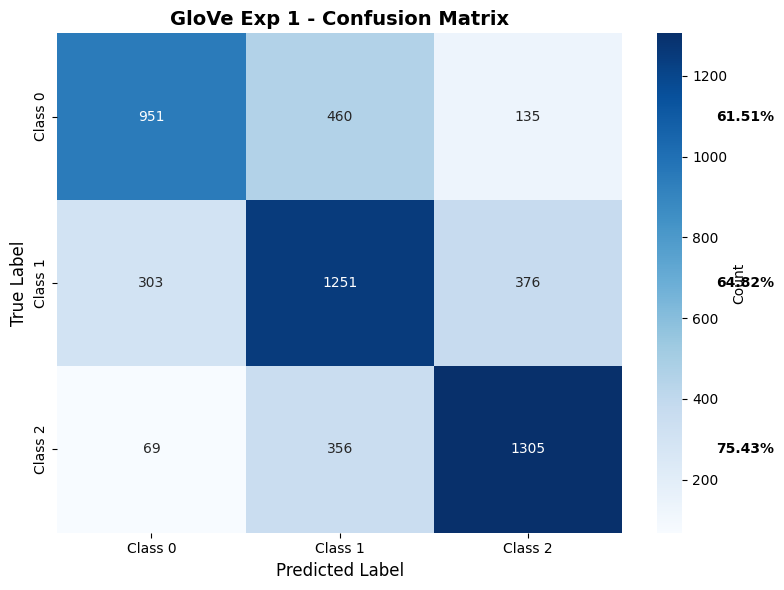

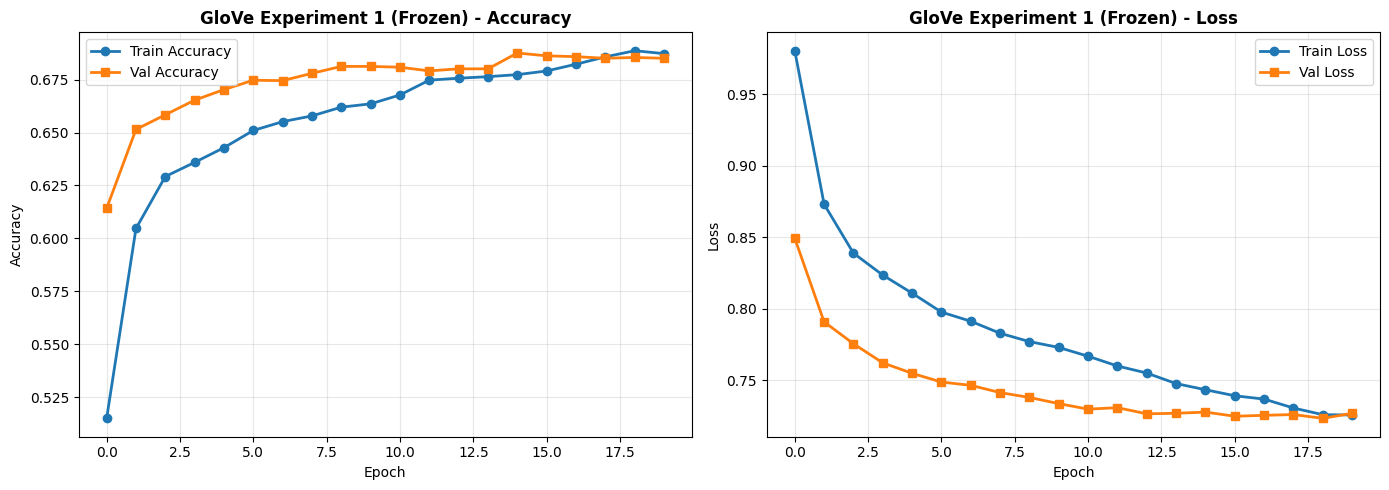

In [17]:
# CELL 17: EXPERIMENT 5 - GloVe + Bidirectional GRU (Frozen Embeddings)
# ============================================
# Variation: Frozen pre-trained embeddings, bidirectional processing

print("\n" + "="*70)
print("🧪 EXPERIMENT 5: GloVe + Bidirectional GRU (Frozen)")
print("="*70)
print("Configuration:")
print("  - GloVe embeddings (100-dim, frozen/non-trainable)")
print("  - Bidirectional GRU (64 units, 128 total)")
print("  - SpatialDropout1D: 0.3")
print("  - Dense layer: 64 units")
print("  - Optimizer: Adam (lr=0.001)")
print("  - Batch size: 64")
print("="*70 + "\n")

# Build model
model_glove_1 = Sequential([
    Embedding(vocab_size_glove, embedding_dim_glove,
              weights=[embedding_matrix_glove],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),  # Frozen embeddings
    SpatialDropout1D(0.3),
    Bidirectional(GRU(64, return_sequences=False)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_glove_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Build model to show shapes
model_glove_1.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
print(model_glove_1.summary())

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

# Train
print("\n🚀 Training Experiment 5...\n")
history_glove_1 = model_glove_1.fit(
    X_train_padded_glove, y_train,
    validation_data=(X_val_padded_glove, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
metrics_glove_1 = evaluate_model(model_glove_1, X_test_padded_glove, y_test, "GloVe Exp 1")
plot_training_history(history_glove_1, "GloVe Experiment 1 (Frozen)")

# Store results
experiment_results.append({
    'Experiment': 'GloVe Exp 1',
    'Embedding': 'GloVe',
    'Description': 'Bi-GRU (128 total), Frozen embeddings',
    **metrics_glove_1
})


🧪 EXPERIMENT 6: GloVe + Stacked Bi-GRU (Trainable)
Configuration:
  - GloVe embeddings (100-dim, trainable/fine-tuned)
  - Stacked Bidirectional GRU (128→64 units)
  - SpatialDropout1D: 0.2
  - Dense layers: 128 → 64 units
  - Optimizer: Adam (lr=0.0005)
  - Batch size: 32



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100, 256)       │       176,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,325,251 (5.06 MB)

 Trainable params: 1,325,251 (5.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Training Experiment 6...

Epoch 1/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.4895 - loss: 0.9975 - val_accuracy: 0.6659 - val_loss: 0.7512 - learning_rate: 5.0000e-04
Epoch 2/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6647 - loss: 0.7810 - val_accuracy: 0.6884 - val_loss: 0.7162 - learning_rate: 5.0000e-04
Epoch 3/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.6992 - loss: 0.7217 - val_accuracy: 0.6978 - val_loss: 0.6998 - learning_rate: 5.0000e-04
Epoch 4/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.7170 - loss: 0.6849 - val_accuracy: 0.7043 - val_loss: 0.7023 - learning_rate: 5.0000e-04
Epoch 5/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.7300 - loss: 0.6483 - val_accuracy: 0.7047 - val_loss: 0.6997 - learning_rate: 5.0000e-04
Epoch 6/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.7433 - loss: 0.6258 - val_accuracy: 0.7039 - val_loss: 0.7156 - learning_rate: 5.0000e-04
Epoch 7/20
976/976

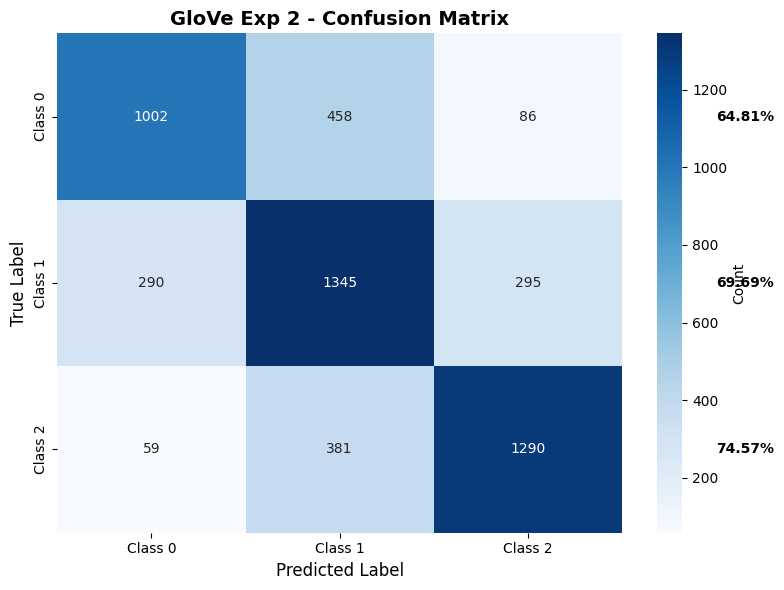

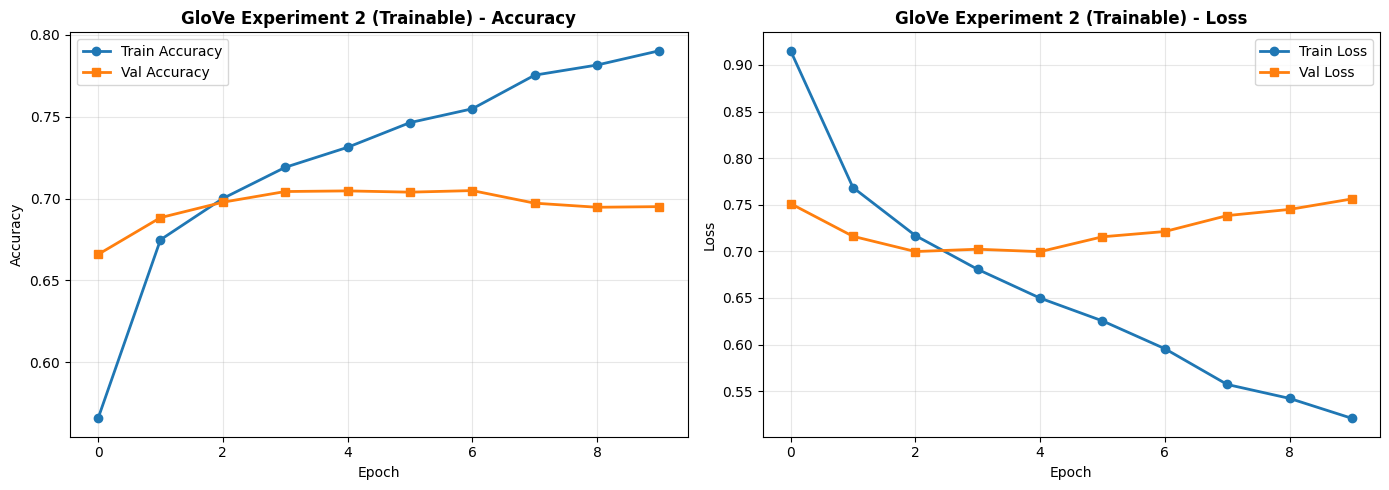

In [18]:
# CELL 18: EXPERIMENT 6 - GloVe + Stacked Bidirectional GRU (Trainable)
# ============================================
# Variation: Trainable embeddings fine-tuned to task, stacked bidirectional GRU for maximum capacity

print("\n" + "="*70)
print("🧪 EXPERIMENT 6: GloVe + Stacked Bi-GRU (Trainable)")
print("="*70)
print("Configuration:")
print("  - GloVe embeddings (100-dim, trainable/fine-tuned)")
print("  - Stacked Bidirectional GRU (128→64 units)")
print("  - SpatialDropout1D: 0.2")
print("  - Dense layers: 128 → 64 units")
print("  - Optimizer: Adam (lr=0.0005)")
print("  - Batch size: 32")
print("="*70 + "\n")

# Build model
model_glove_2 = Sequential([
    Embedding(vocab_size_glove, embedding_dim_glove,
              weights=[embedding_matrix_glove],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True),  # Trainable embeddings
    SpatialDropout1D(0.2),
    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(GRU(64, return_sequences=False)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_glove_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Build model to show shapes
model_glove_2.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
print(model_glove_2.summary())

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

# Train
print("\n🚀 Training Experiment 6...\n")
history_glove_2 = model_glove_2.fit(
    X_train_padded_glove, y_train,
    validation_data=(X_val_padded_glove, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
metrics_glove_2 = evaluate_model(model_glove_2, X_test_padded_glove, y_test, "GloVe Exp 2")
plot_training_history(history_glove_2, "GloVe Experiment 2 (Trainable)")

# Store results
experiment_results.append({
    'Experiment': 'GloVe Exp 2',
    'Embedding': 'GloVe',
    'Description': 'Stacked Bi-GRU (256→128), Trainable embeddings',
    **metrics_glove_2
})

# EXPERIMENT RESULTS COMPARISON

This section provides a comprehensive comparison of all experiments.


📊 COMPREHENSIVE EXPERIMENT RESULTS

    Experiment Embedding                                    Description  accuracy  precision  recall  f1_score
  TF-IDF Exp 1    TF-IDF             Simple GRU (64 units), Dropout 0.3    0.3707     0.1374  0.3707    0.2005
  TF-IDF Exp 2    TF-IDF     Bidirectional GRU (128 total), Dropout 0.4    0.3707     0.1374  0.3707    0.2005
Word2Vec Exp 1  Word2Vec   Single GRU (128 units), Trainable embeddings    0.3707     0.1374  0.3707    0.2005
Word2Vec Exp 2  Word2Vec           Stacked GRU (128→64), Deeper network    0.3707     0.1374  0.3707    0.2005
   GloVe Exp 1     GloVe          Bi-GRU (128 total), Frozen embeddings    0.6736     0.6766  0.6736    0.6735
   GloVe Exp 2     GloVe Stacked Bi-GRU (256→128), Trainable embeddings    0.6986     0.7051  0.6986    0.6999


🏆 BEST PERFORMING MODELS:

Highest Accuracy: GloVe Exp 2
  - Accuracy: 0.6986
  - F1-Score: 0.6999

Highest F1-Score: GloVe Exp 2
  - Accuracy: 0.6986
  - F1-Score: 0.6999




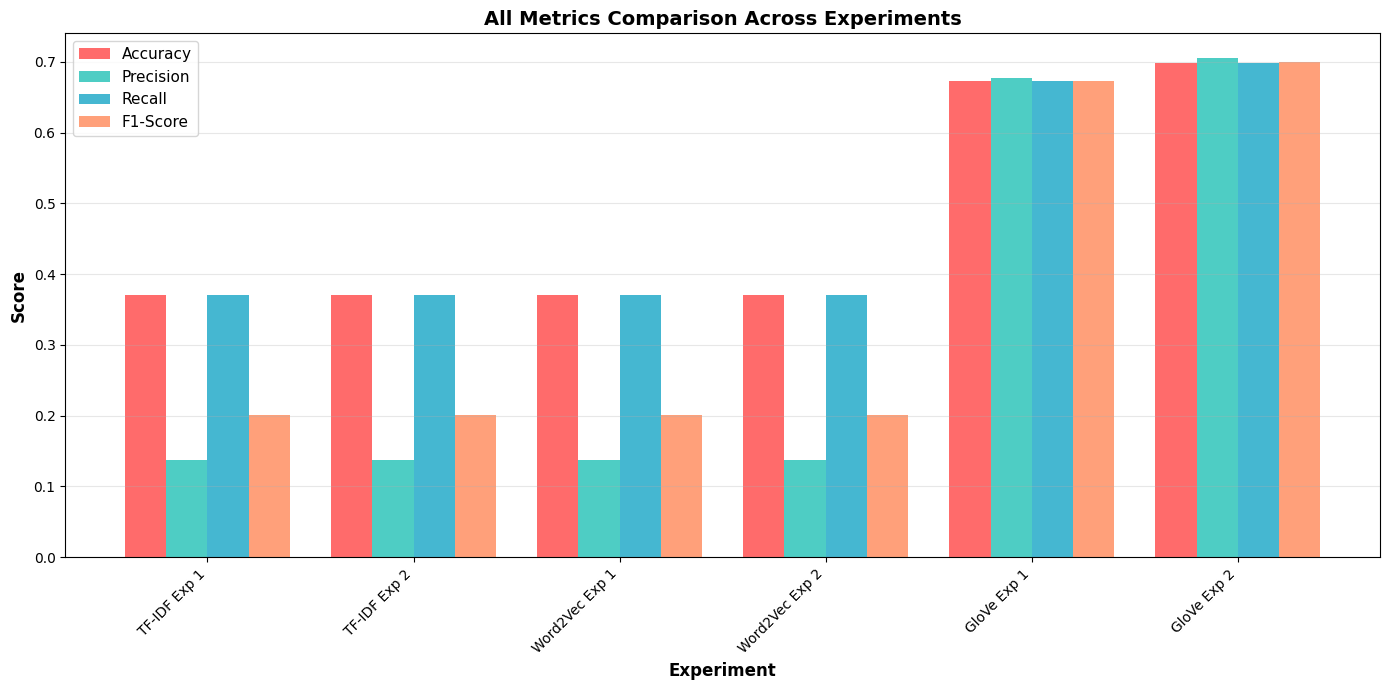


📈 SUMMARY BY EMBEDDING TYPE:
          accuracy         precision          recall         f1_score        
              mean     max      mean     max    mean     max     mean     max
Embedding                                                                    
GloVe       0.6861  0.6986   0.69085  0.7051  0.6861  0.6986   0.6867  0.6999
TF-IDF      0.3707  0.3707   0.13740  0.1374  0.3707  0.3707   0.2005  0.2005
Word2Vec    0.3707  0.3707   0.13740  0.1374  0.3707  0.3707   0.2005  0.2005

✅ Analysis complete!


In [20]:
# CELL 19: RESULTS TABLE AND COMPARISON
# ============================================

print("\n" + "="*80)
print("📊 COMPREHENSIVE EXPERIMENT RESULTS")
print("="*80 + "\n")

# Create results dataframe
results_df = pd.DataFrame(experiment_results)

# Round metrics for better display
for col in ['accuracy', 'precision', 'recall', 'f1_score']:
    results_df[col] = results_df[col].round(4)

# Display table
print(results_df.to_string(index=False))
print("\n" + "="*80 + "\n")

# Find best models
best_accuracy = results_df.loc[results_df['accuracy'].idxmax()]
best_f1 = results_df.loc[results_df['f1_score'].idxmax()]

print("🏆 BEST PERFORMING MODELS:")
print(f"\nHighest Accuracy: {best_accuracy['Experiment']}")
print(f"  - Accuracy: {best_accuracy['accuracy']:.4f}")
print(f"  - F1-Score: {best_accuracy['f1_score']:.4f}")

print(f"\nHighest F1-Score: {best_f1['Experiment']}")
print(f"  - Accuracy: {best_f1['accuracy']:.4f}")
print(f"  - F1-Score: {best_f1['f1_score']:.4f}")

print("\n" + "="*80 + "\n")

# Visualization 2: Grouped comparison by embedding type
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(results_df))
width = 0.2

ax.bar(x - 1.5*width, results_df['accuracy'], width, label='Accuracy', color='#FF6B6B')
ax.bar(x - 0.5*width, results_df['precision'], width, label='Precision', color='#4ECDC4')
ax.bar(x + 0.5*width, results_df['recall'], width, label='Recall', color='#45B7D1')
ax.bar(x + 1.5*width, results_df['f1_score'], width, label='F1-Score', color='#FFA07A')

ax.set_xlabel('Experiment', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('All Metrics Comparison Across Experiments', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Experiment'], rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary by embedding type
print("\n📈 SUMMARY BY EMBEDDING TYPE:")
summary_by_embedding = results_df.groupby('Embedding')[['accuracy', 'precision', 'recall', 'f1_score']].agg(['mean', 'max'])
print(summary_by_embedding)

print("\n✅ Analysis complete!")